In [1]:
%matplotlib notebook
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("/home/pablo/CinePy")
from constantes.lectura import lee_constantes_retardados
from constantes.constantes_reactores import RA1 
from modules.point_kinetics.reactimeter import reactimetro
from modules.point_kinetics.soluciones_analiticas import solucion_analitica_Ia


# Solución de la cinética puntual para un salto en escalón



In [2]:
# Se leen juego de cosntantes nucleares de neutrones retardados
b, lam , beta = lee_constantes_retardados('Tuttle')

# Se leen constantes características de cada reactor
Lambda_red = RA1.LAMBDA_REDUCIDO

constantes_cineticas = b, lam, Lambda_red

In [3]:
# Tiempo máximo de la integración
tmax = 30
# Cantidad de puntos
Npunt = 10000
# Vector temporal (para odeint)
t = np.linspace(0.0, tmax, Npunt)
# Paso de integración (para ode)
dt = t[1]-t[0]
print('Resolución temporal : {:.4e}'.format(dt))

Resolución temporal : 3.0003e-03


## Solución analítica de un salto en escalón de reactividad

Para un reactor inicialmente crítico y estacionario en un valor $n_0$ (sin fuente externa de neutrones), a un tiempo $t_0$ se produce un cambio de reactividad $\$_0$ de forma instantánea.

La solución exacta de esta evolución es:

\begin{align}
n(t < t_0 ) &= n_0 \\
n(t\ge t_0) &= n_0 \sum_{i=1}^7 B_i e^{\omega_i (t-t_0)}
\end{align}


donde los coeficientes $B_i$ se definen como:

\begin{equation}
B_i = \frac{\$_0 / \omega_i}{\Lambda^*  + \sum_{j=1}^6 \frac{b_j\lambda_j}{(\omega_i + \lambda_j)^2}}
\end{equation}

y los $\omega_i$ son las soluciones de la ecuación in-hour:

\begin{equation}
\$_0 = \Lambda^* \omega + \omega \sum_{i=1}^6 \frac{b_i}{\omega + \lambda_i}
\end{equation}

### Definición de parámetros:

In [4]:
# Cambio en reactividad (en dólares)
rho = -1   
# Tiempo del salto instantáneo
t0 = 2
# Valor inicial
n0 = 2

### Solución:

<IPython.core.display.Javascript object>


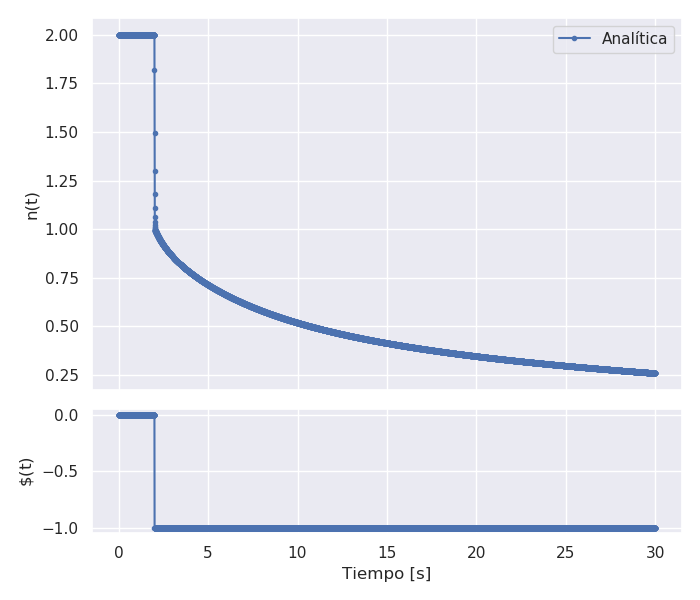

In [5]:
# Encuentro la solución analítica
n_analitica = solucion_analitica_Ia(t, rho, t0, n0, constantes_cineticas)

# Graficación
fig, ax = plt.subplots(2, 1, figsize=(7,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax[0].plot(t, n_analitica, '.-', label='Analítica') 
ax[0].set_yscale('linear')
ax[0].set_ylabel('n(t)')
ax[0].legend()
# ax[0].set_ylim(0, 5)

reactividad = rho * np.ones_like(t)
reactividad[t<t0] = 0.0
ax[1].plot(t, reactividad, '.-')
ax[1].set_ylabel(r'$\$$(t)')
ax[1].set_xlabel('Tiempo [s]')

fig.tight_layout()

## Solución numérica

In [6]:
def salto_instantaneo_numerico(t, rho, t0, n0):
    """ Función para resolver X' = AX """
    b, lam, Lambda_red = constantes_cineticas
    
    # Construyo a la matríz A
    A = np.zeros((7,7))
    A[1:, 1:] = np.diag(-lam)
    A[0, 1: ] = lam
    A[1:, 0] = b / Lambda_red
    
    # Construyo el vector X inicial
    X0 = b / lam / Lambda_red * n0
    X0 = np.insert(X0, 0, n0)
    
    def func_ode(t, X, P):
        # Salto instantáneo en reactividad
        _rho = 0.0 if t < t0 else rho
        # Sólo P(0,0) depende del tiempo
        P[0, 0] = (_rho-1) / Lambda_red
        return np.matmul(P, X)
   
    # ------ Se resuelve utilizando scipy.integrate.ode
    dt = t[1] - t[0]
    r = ode(func_ode)
    r.set_integrator('dopri5')
    # r.set_integrator('lsoda')
    r.set_initial_value(X0, 0.0)
    r.set_f_params(A)
    
    t_ode = []
    y_ode = []
    while r.successful() and r.t <= tmax+dt:
        t_ode.append(r.t)
        y_ode.append(r.y)
        r.integrate(r.t+dt) 
    
    t_ode = np.asarray(t_ode)
    y_ode = np.asarray(y_ode)
    return y_ode[0:len(t)], t_ode[0:len(t)]

<IPython.core.display.Javascript object>


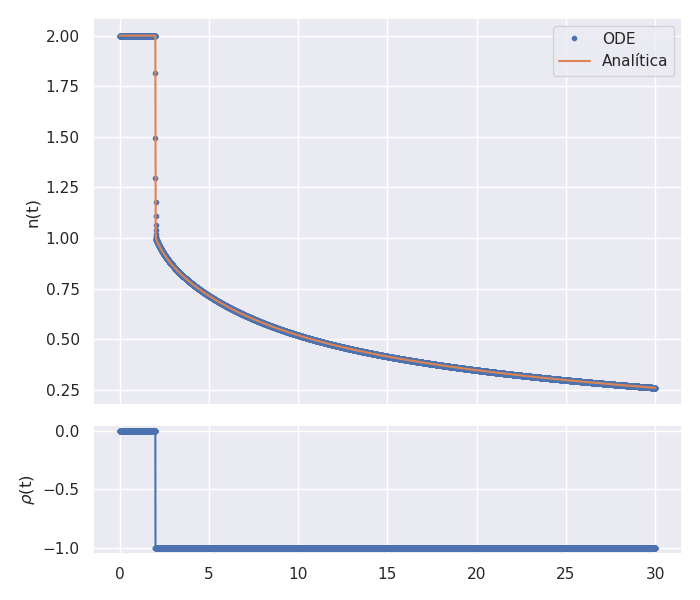

In [7]:
n_ode, t_ode = salto_instantaneo_numerico(t, rho, t0, n0)

# Graficación
fig, ax = plt.subplots(2, 1, figsize=(7,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax[0].plot(t_ode, n_ode[:, 0], '.', label='ODE') 
ax[0].plot(t, n_analitica, '-', label='Analítica') 
ax[0].set_yscale('linear')
ax[0].set_ylabel('n(t)')
ax[0].legend()

reactividad = rho * np.ones_like(t)
reactividad[t<t0] = 0.0
ax[1].plot(t, reactividad, '.-')
ax[1].set_ylabel(r'$\rho$(t)')

fig.tight_layout();

## Ajuste del modelo


In [ ]:
from lmfit import Minimizer, Parameters, report_fit
from scipy.stats import norm

def invertir_orden_leyenda(ax, loc='best'):
    """ Necesario por bug en plt.errorbar"""
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='best')

Primero genero la señal que voy a ajustar y le agrego ruido Gaussiano

In [ ]:
# Parámetros que voy a simular
rho, t0, n0 = -1, 2, 9

# Solución analítica
n_analitica = salto_instantaneo_analitico(t, rho, t0, n0)

# Amplitud del ruido
amp_ruid = 0.01 * n0
# Ruido Gaussiano
n_ruid = amp_ruid * np.random.normal(size=n_analitica.shape )
# Funcón simulada
n_sim = n_analitica + n_ruid

# Graficación
fig, ax = plt.subplots(1,1)
ax.plot(t, n_sim, label='Simulada')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('n(t)')
ax.legend();

## Ajuste usando función analítica como modelo

In [ ]:
# Defino la función objetivo

def residual_analitico(params, t, data=None, sigma=None):
    parvals = params.valuesdict()
    rho = parvals['rho']
    t0 = parvals['t0']
    n0 = parvals['n0']

    model = salto_instantaneo_analitico(t, rho, t0, n0) 

    if data is None:
        return model
    if sigma is None:
        return model - data
    return (model - data) / sigma

In [ ]:
# Parametros iniciales
param_ini = -2, 5, 1

# Se definen los parámetros del ajuste
params = Parameters()
params.add('rho', value=param_ini[0], max=0)
params.add('t0', value=param_ini[1], min=0)
params.add('n0', value=param_ini[2], min=0)

# Se define la minimización
minner = Minimizer(residual_analitico, params,
                   fcn_args=(t,),
                   fcn_kws={'data': n_sim, 'sigma': amp_ruid}
                   ) 

In [ ]:
# Se realiza la minimización de la función objetivo
metodos = 'nelder', 'leastsq'
results = [minner.minimize(method=metodo) for metodo in metodos]
[report_fit(result) for result in results];

In [ ]:
result = results[0]
best_fit = n_sim + result.residual * amp_ruid

fig, (ax0, ax1) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]},
                               )
# Grafico de ajuste
ax0.errorbar(t, n_sim, yerr=n_ruid, fmt='.', elinewidth=2,
             label='measurement', capsize=4)
ax0.plot(t, best_fit, 'r', zorder=3, label='fit', lw=2)
ax0.set_ylabel(r'$n(t)$')
ax0.set_title('Ajuste con modelo analítico')

# Gráfico de residuos
ax1.plot(t, result.residual )
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'Residuals')
fig.subplots_adjust(hspace=0.1)

# Graficación del histograma de los residuos
fig2, ax3 = plt.subplots(1, 1)
ax3.hist(result.residual, bins=20, density=True, label='Residuals',
         histtype='stepfilled')
res_mean = np.mean(result.residual)
res_std = np.std(result.residual, ddof=1)
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 500)
# Agrego la pdf de una Gaussiana con valor medio y desvío obtenido de los residuos
ax3.plot(x, norm.pdf(x, loc=res_mean, scale=res_std),
         'r-', lw=4, alpha=0.6, label='Normal pdf')

[invertir_orden_leyenda(ax) for ax in (ax0, ax3)];

## Ajuste usando la solución numérica como modelo

In [ ]:
def residual_num(params, t, data=None, sigma=None):
    parvals = params.valuesdict()
    rho = parvals['rho']
    t0 = parvals['t0']
    n0 = parvals['n0']

    model, _ = salto_instantaneo_numerico(t, rho, t0, n0) 
    model = model[:, 0]

    if data is None:
        return model
    if sigma is None:
        return model - data
    return (model - data) / sigma


In [ ]:
# Parametros iniciales
param_ini = -2, 5, 2

# Se definen los parámetros del ajuste
params = Parameters()
params.add('rho', value=param_ini[0], max=0)
params.add('t0', value=param_ini[1], min=0)
params.add('n0', value=param_ini[2], min=0, vary=True)

# Se define la minimización
minner = Minimizer(residual_num, params,
                   fcn_args=(t,),
                   fcn_kws={'data': n_sim, 'sigma': amp_ruid}
                   ) 

In [ ]:
# Se realiza la minimización de la función objetivo
# metodos = 'nelder', 'leastsq', 'force'
metodos = 'nelder',
results = [minner.minimize(method=metodo) for metodo in metodos]
[report_fit(result) for result in results];

# Se pueden usar métodos en serie
# out1 = minner.minimize(method='nelder')
# result = minner.minimize(method='leastsq', params=out1.params)
# report_fit(result)

In [ ]:
result = results[0]
best_fit = n_sim + result.residual * amp_ruid

fig, (ax0, ax1) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]},
                               )
# Grafico de ajuste
ax0.errorbar(t, n_sim, yerr=n_ruid, fmt='.', elinewidth=2,
             label='measurement', capsize=4)
ax0.plot(t, best_fit, 'r', zorder=3, label='fit', lw=2)
ax0.set_ylabel(r'$n(t)$')
ax0.set_title('Ajuste con modelo numérico')

# Gráfico de residuos
ax1.plot(t, result.residual )
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'Residuals')
fig.subplots_adjust(hspace=0.1)

# Graficación del histograma de los residuos
fig2, ax3 = plt.subplots(1, 1)
ax3.hist(result.residual, bins=20, density=True, label='Residuals',
         histtype='stepfilled')
res_mean = np.mean(result.residual)
res_std = np.std(result.residual, ddof=1)
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 500)
# Agrego la pdf de una Gaussiana con valor medio y desvío obtenido de los residuos
ax3.plot(x, norm.pdf(x, loc=res_mean, scale=res_std),
         'r-', lw=4, alpha=0.6, label='Normal pdf')

[invertir_orden_leyenda(ax) for ax in (ax0, ax3)];